In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.fftpack as fft
from astropy.io import fits
from scipy import optimize
from poppy import zernike
from scipy import signal
import os
import pytz
import time
import re

/Users/MelisaT/anaconda/lib/python3.6/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/MelisaT/anaconda/lib/python3.6/site-packages/pysynphot/locations.py:329: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


Parameters

In [2]:
outD = 7.77010            # primary diameter (m)
inD = 1.024               # inner M2 diameter (m)
n = 48                    # number sample points across the screen (Not the number of subapertures)
nacross = 43              # number of subapertures across the aperture
pscale = outD/(nacross)   # pixel size (m) of samples in pupil plane

Aperture

In [3]:
#  Aperture containing zeros
x = np.linspace(-(n)/2,(n)/2,n)*pscale 
y = np.linspace(-(n)/2,(n)/2,n)*pscale
mg = np.meshgrid(x,y)
ar = np.sqrt(np.sum((m**2 for m in mg)))
ap_outer = (ar <= (7.3)/2)
ap_inner = (ar <= 1.5/2)   
ap = (ap_outer ^ ap_inner).astype(int)

#  Aperture containing nans
ap_nan = np.copy(ap.astype(np.float))  
ap_nan[np.where(ap==0)] = np.nan

Directory Paths

In [67]:
dome_seeing = "/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Reduced/20160227/aored_When_2016.2.27_1.35.6_poldm_phase.fits"
clean_seeing = "/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Reduced/20160229/aored_When_2016.2.29_22.29.18_poldm_phase.fits"
save_path = "/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Results/temp_power_spec/"
dstr = time.strftime('%Y%m%d')

Process Image

In [68]:
hdulist = fits.open(clean_seeing,memmap=True)
phase = hdulist[0].data.astype('float')
timesteps, phx, phy = phase.shape            # contains a datacube
avg_phase = np.nanmean(phase*ap_nan,axis=0)  # used to find average zernikes 
    
# remove zernikes form cube
z_basis = zernike.zernike_basis_faster(nterms= 6, npix = 48)
z_coeff = zernike.opd_expand_nonorthonormal(avg_phase, aperture=ap, nterms=6)
thin_lens = np.sum(z_coeff[:,None,None]*z_basis[:,:,:],axis=0)

c_phase = (phase - thin_lens[None,:,:])*ap_nan
c_phase[np.isnan(c_phase)]=0.
avg_c_phase = np.mean(c_phase,axis=(1,2))
print('Done processing image')

/Users/MelisaT/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


Done processing image


Power spec

In [69]:
n = len(avg_c_phase)
dT = .001

w = signal.blackman(n)
P = np.fft.rfft(avg_c_phase*w)
norm = 2.0/n
P = P * norm

P2 = np.square(np.abs(P))
k = np.fft.rfftfreq(n,dT)

Smoothing

In [70]:
smoothed = 10**signal.savgol_filter(np.log10(P2), 101, 5) 

Linear fit

In [72]:
par = np.polyfit(np.log10(k[(k>10.) & (k<40.)]), np.log10(smoothed[(k>2.) & (k<40.)]), 1)
slope = par[0]
intercept = par[1]

print(slope)
print(intercept)

-2.97478434883
-3.06606222955


Plot power spec

<IPython.core.display.Javascript object>


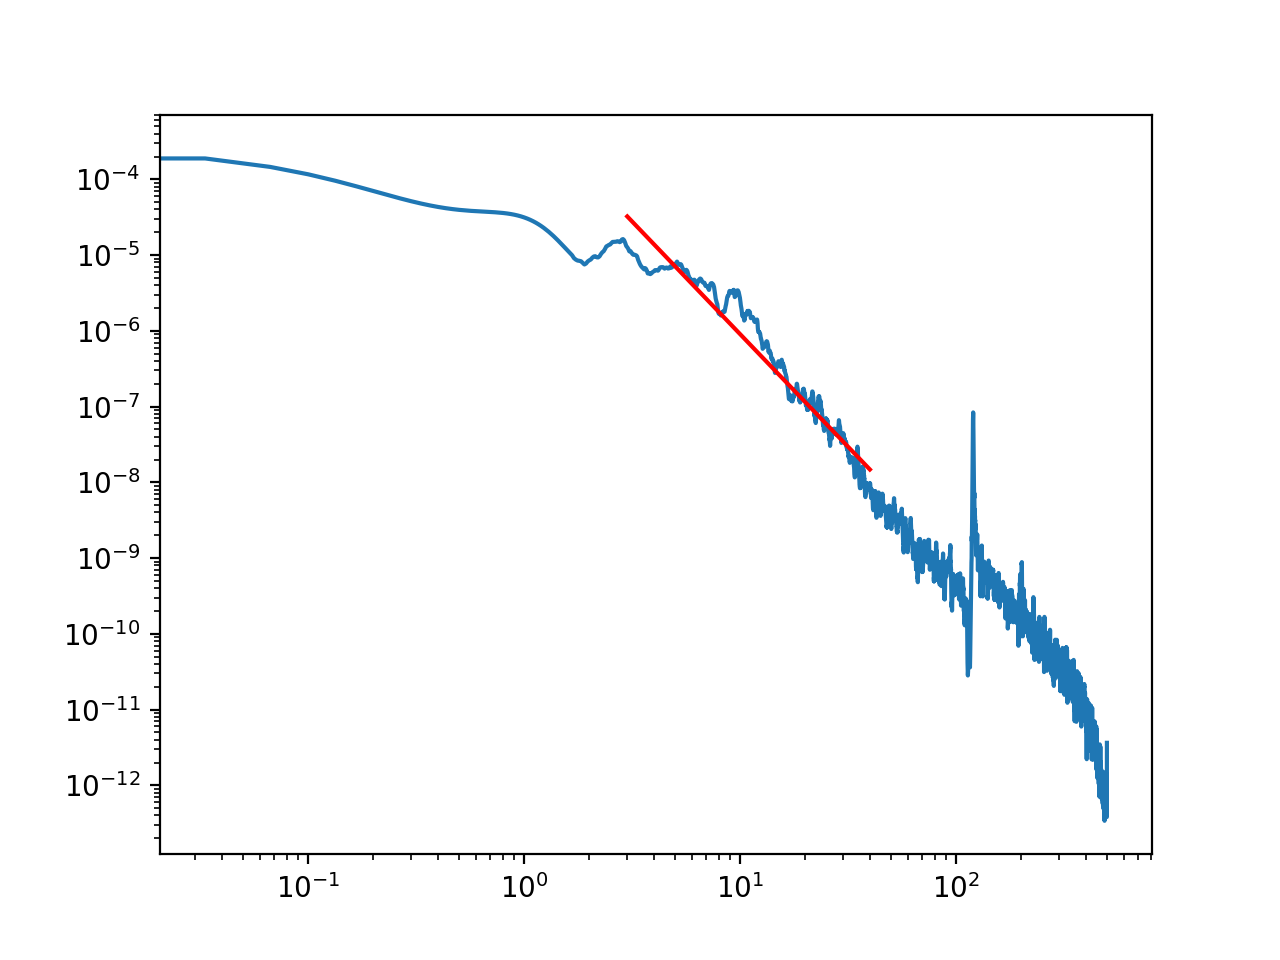

In [73]:
%matplotlib notebook

plt.figure(1)
#plt.loglog(k,P2)
plt.loglog(k,smoothed)
plt.loglog(k[(k>3.) & (k<40.)], (10**intercept)*k[(k>3.) & (k<40.)]**slope, 'r')